# Forward model

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

In [2]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import rand_volume, volume_fourier
from src.projection import project, rotate
from src.interpolate import interpolate

In [3]:
# Create a volume

nx = 128
shape = nx * np.ones(3, dtype=np.int32)
dimensions = 10 * np.ones(3)
radius = 2
centre = np.array([1,0,0])
sigma = 10

v, X, Y, Z = rand_volume(shape, dimensions, centre, radius, sigma)

In [4]:
# Take the Fourier transform, rotate 
# and interpolate the new z=0 slice

v_f, X_f, Y_f, Z_f, _, _, _ = volume_fourier(v, dimensions)

#angles = np.array([np.pi/3, np.pi/10, 3*np.pi/4])
angles = np.array([0,0,0])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f, Z_f, angles)

Text(0.5, 1.0, 'Volume slice')

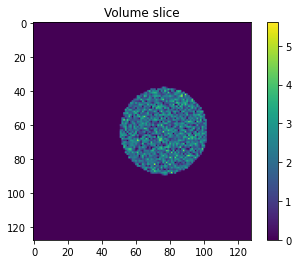

In [5]:
plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume slice')

Text(0.5, 1.0, 'Vol FFT slice')

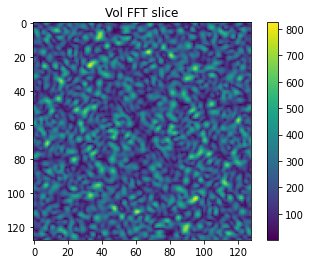

In [6]:
plt.imshow(np.fft.fftshift(abs(v_f[:,:,int(np.floor(v.shape[2]/2))])))
plt.colorbar()

plt.title('Vol FFT slice')

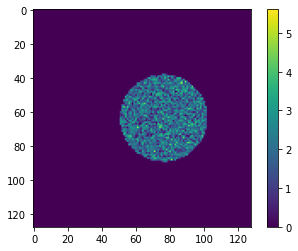

In [7]:
iv_f = np.fft.ifftn(v_f)
plt.imshow(np.real(iv_f[:,:,int(np.floor(v.shape[2]/2))]))
plt.colorbar()

Text(0.5, 1.0, 'X_f coords')

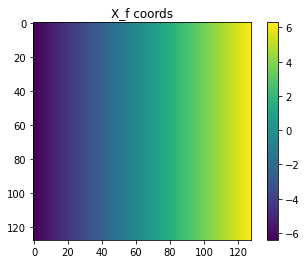

In [8]:
plt.imshow(np.fft.fftshift(X_f[:,:,0]))
plt.colorbar()
plt.title('X_f coords')

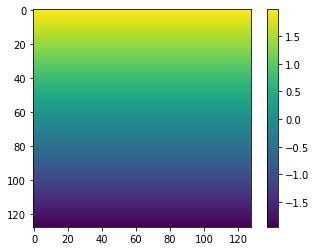

In [9]:
alpha = np.pi/10
beta = 15*np.pi/3
gamma = 3*np.pi/4
angles = np.array([alpha, beta, gamma])
X_fr, Y_fr, Z_fr = rotate(X_f, Y_f, Z_f, angles)
plt.imshow(np.fft.fftshift(Z_fr[:,:,0]))
#plt.imshow(Z_fr[:,:,0])
plt.colorbar()

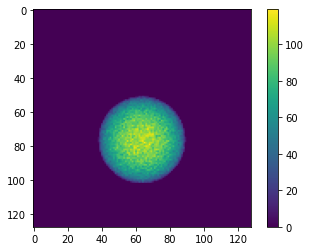

In [10]:
angles = np.array([0,0,0])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f, Z_f, angles)

plt.imshow(np.real(np.fft.ifftn(slice_interp_2d)))
plt.colorbar()